In [1]:
from scipy.io import loadmat
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import calendar
import os
import psutil
import math

In [2]:
fileDrive = r'C:\Users\mikel\Desktop\Guosheng\Daily'
#fileDrive = 'D:\\HKUST\\GuoshenIntern\\Redo\\RawData\\'
startDay = 20130327
endDay = 20180105 + 1
offsetWindow = 60
tradingDateAll = loadmat(os.path.join(fileDrive,'TradingDate_Daily.mat'))['TradingDate_Daily'][:,0]    # one column, a row per day
startDayIndex = np.array(np.where(tradingDateAll>=startDay))[0][0]
endDayIndex = np.array(np.where(tradingDateAll>=endDay))[0][0]
tradingDate = tradingDateAll[startDayIndex : endDayIndex]

In [3]:
allStockCode = pd.Series(loadmat(os.path.join(fileDrive,'AllStockCode.mat'))['AllStockCode'][0])
allStockCode = allStockCode.apply(lambda x : x[0]).values

In [4]:
isIndexDF = pd.read_csv(os.path.join(fileDrive,'isIndexDF.csv'),header=0,index_col=0)
openPrice = loadmat(os.path.join(fileDrive,'AllStock_DailyOpen_dividend.mat'))['AllStock_DailyOpen_dividend'][startDayIndex:endDayIndex]
openPriceDF = pd.DataFrame(openPrice,index=tradingDate,columns=allStockCode)
closePrice = loadmat(os.path.join(fileDrive,'AllStock_DailyClose_dividend.mat'))['AllStock_DailyClose_dividend'][startDayIndex:endDayIndex]
closePriceDF = pd.DataFrame(closePrice,index=tradingDate,columns=allStockCode)
lowPrice = loadmat(os.path.join(fileDrive,'AllStock_DailyLow_dividend.mat'))['AllStock_DailyLow_dividend'][startDayIndex:endDayIndex]
lowPriceDF = pd.DataFrame(lowPrice,index=tradingDate,columns=allStockCode)
highPrice = loadmat(os.path.join(fileDrive,'AllStock_DailyHigh_dividend.mat'))['AllStock_DailyHigh_dividend'][startDayIndex:endDayIndex]
highPriceDF = pd.DataFrame(lowPrice,index=tradingDate,columns=allStockCode)
dailyListedDate = loadmat(os.path.join(fileDrive,'AllStock_DailyListedDate.mat'))['AllStock_DailyListedDate'][startDayIndex:endDayIndex]
dailyListedDateDF = pd.DataFrame(dailyListedDate,index=tradingDate,columns=allStockCode)
dailyST = loadmat(os.path.join(fileDrive,'AllStock_DailyST.mat'))['AllStock_DailyST'][startDayIndex:endDayIndex]
dailySTDF = pd.DataFrame(dailyST,index=tradingDate,columns=allStockCode)
dailyStatus = loadmat(os.path.join(fileDrive,'AllStock_DailyStatus.mat'))['AllStock_DailyStatus_use'][startDayIndex:endDayIndex]
dailyStatusDF = pd.DataFrame(dailyStatus,index=tradingDate,columns=allStockCode)
dailyTR = loadmat(os.path.join(fileDrive,'AllStock_DailyTR.mat'))['AllStock_DailyTR'][startDayIndex:endDayIndex]
dailyTRDF = pd.DataFrame(dailyTR,index=tradingDate,columns=allStockCode)

In [5]:
isValidDF = isIndexDF[(dailyListedDateDF > 60) & (openPriceDF != closePriceDF.shift(1)) & (dailySTDF == 0) & (dailyStatusDF == 1) & (dailyStatusDF.shift(1) == 1)]

In [6]:
# 重新定义isValid, 只选高开样本
isValidDF = isIndexDF[(dailyListedDateDF > 60) & (openPriceDF > closePriceDF.shift(1)) & (dailySTDF == 0) & (dailyStatusDF == 1) & (dailyStatusDF.shift(1) == 1) ]

In [7]:
dailyReturnDF = pd.DataFrame(None, index=tradingDate,columns=allStockCode)
dailyReturnDF[isValidDF == 1] =  closePriceDF / openPriceDF - 1
dailyReturnDF[(isValidDF == 1) & (lowPriceDF/closePriceDF.shift(1) - 1 < -0.098)] = lowPriceDF / openPrice - 1

In [8]:
gaoKaiFuDuDF = pd.DataFrame(data = None,index=tradingDate,columns=allStockCode)
gaoKaiFuDuDF[isValidDF == 1] = openPriceDF / closePriceDF.shift(periods=1, axis=0) - 1

def gaoKaiBand(theDate):
    return (gaoKaiFuDuDF.loc[theDate].rank()/gaoKaiFuDuDF.loc[theDate].count()*10).apply(lambda x: math.ceil(x) if x>0 else np.nan)
gaoKaiBandDF = gaoKaiFuDuDF.apply(lambda x : gaoKaiBand(x.name), axis = 1)
gaoKaiBandDF.to_csv(os.path.join(fileDrive,'New\gaoKaiBandDF.csv'), header=True, index=True)

In [9]:
gaoKaiBandDF = pd.read_csv(os.path.join(fileDrive,'New\gaoKaiBandDF.csv'), header=0, index_col=0)

In [10]:
gaoKaiBandReturn = np.zeros(10)
gaoKaiBandCount = np.zeros(10)
for i in range(10):
    gaoKaiBandReturn[i] = dailyReturnDF[gaoKaiBandDF==i+1].mean(axis=1).mean()
    # diKaiBandCount[i] = dailyReturnDF[diKaiRankDF==i+1].apply(lambda x : 1 if x == i else 0).sum().sum()
    gaoKaiBandCount[i] = (gaoKaiBandDF == i + 1).sum().sum()

In [11]:
gaoKaiBandReturn = np.zeros(10)
gaoKaiBandCount = np.zeros(10)
for i in range(10):
    gaoKaiBandReturn[i] = dailyReturnDF[gaoKaiBandDF==i+1].mean(axis=1).mean()
    # diKaiBandCount[i] = dailyReturnDF[diKaiRankDF==i+1].apply(lambda x : 1 if x == i else 0).sum().sum()
    gaoKaiBandCount[i] = (gaoKaiBandDF == i + 1).sum().sum()

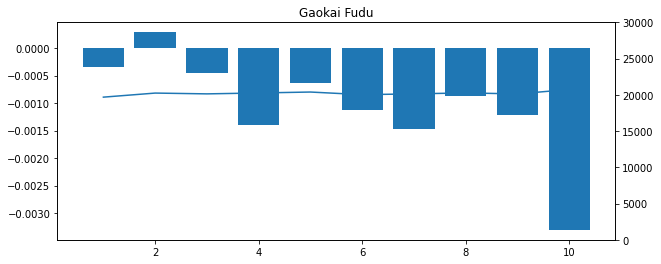

In [12]:
fig = plt.figure(figsize = [10,4])
ax1 = fig.add_subplot(111)
ax1.set_title('Gaokai Fudu')
ax1.bar(range(1,len(gaoKaiBandReturn)+1), gaoKaiBandReturn)
ax2 = ax1.twinx()
ax2.plot(range(1,len(gaoKaiBandReturn)+1), gaoKaiBandCount)
ax2.set_yticks([i*5000 for i in range(7)])
plt.show()

%%time
# a time-consuming task, taking 20 minutes
def turnoverQ(x):
    rank =  ((x.rank()).values)[-1]
    return rank / x.count() 
turnoverQDF = dailyTRDF.shift(1).rolling(60).apply(turnoverQ,raw = False)
turnoverQDF = turnoverQDF[isValidDF==1]
def turnoverBand(theDate):
    return (turnoverQDF.loc[theDate].rank()/turnoverQDF.loc[theDate].count()*6).apply(lambda x: math.ceil(x) if x>0 else np.nan)

turnoverBandDF = turnoverQDF.apply(lambda x : turnoverBand(x.name), axis = 1)

turnoverQDF.to_csv(os.path.join(fileDrive,'New\\turnoverQDF1.csv'), header=True, index=True)
turnoverBandDF.to_csv(os.path.join(fileDrive,'New\\turnoverBandDF1.csv'), header=True, index=True)

In [13]:
turnoverQDF = pd.read_csv(os.path.join(fileDrive,'New\\turnoverQDF1.csv'), header=0, index_col=0)
turnoverBandDF = pd.read_csv(os.path.join(fileDrive,'New\\turnoverBandDF1.csv'), header=0, index_col=0)

In [14]:
turnoverBandReturn = np.zeros(6)
turnoverBandCount = np.zeros(6)
for i in range(6):
    turnoverBandReturn[i] = dailyReturnDF[turnoverBandDF==i+1].mean(axis=1).mean()
    turnoverBandCount[i] = (turnoverBandDF == i + 1).sum().sum()

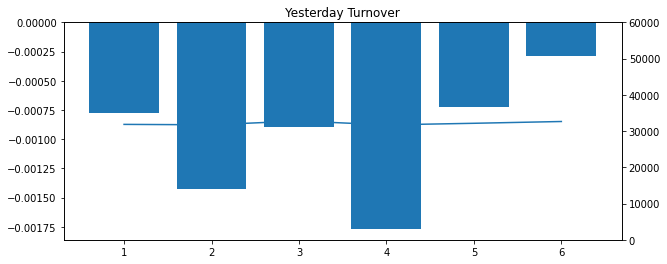

In [15]:
fig = plt.figure(figsize = [10,4])
ax1 = fig.add_subplot(111)
ax1.set_title('Yesterday Turnover')
ax1.bar(range(1,len(turnoverBandReturn)+1), turnoverBandReturn)
ax2 = ax1.twinx()
ax2.plot(range(1,len(turnoverBandCount)+1), turnoverBandCount)
ax2.set_yticks([i*10000 for i in range(7)])
plt.show()

In [16]:
# 辅助函数，用于计算值X在数组V中的排序位置
def percentile_rank(x,v):
    return (v <= x).sum() / len(v)

In [17]:
openningQuanPercentileDF = pd.DataFrame(None,index=tradingDate,columns=allStockCode)
openningQuanBandDF = pd.DataFrame(None,index=tradingDate,columns=allStockCode)

In [18]:
minuteDataF = loadmat(r'C:\Users\mikel\Desktop\data\UnAdjstedStockMinute_' + allStockCode[50][0:6] + '.mat')

In [38]:
%%time
#taking 13 minutes
#minutesDataColumns = ['交易日','分开盘','分高价','分低价','分收盘','成交量','成交额']
missingFileCodes = []
for stockCode in allStockCode:
    try: 
        minuteDataF = loadmat(r'C:\Users\mikel\Desktop\data\UnAdjstedStockMinute_' + stockCode[0:6] + '.mat')
    except Exception as e:
        missingFileCodes.append(stockCode)
        continue
    minuteData = minuteDataF['UnAdjstedStockMinute_'+stockCode[0:6]]
    for i in range(offsetWindow, min(int(minuteData.size/7/242),tradingDate.size)):     #从 offsetWindow = 60（2013.7.1)开始统计，前60天从2013.3.27开始. 分钟数据从2013.3.26开始
        if isValidDF[stockCode].iloc[i] == 1:
            openningQuanList = []
            for k in range(offsetWindow):
                #下面这行代码应该是4，不是5
                openningQuanList.append(minuteData[(i-offsetWindow+k)*242][4])    # 数据第一天是2013.3.26，每天242行数据
            openningQuanArray = np.array(openningQuanList)
            #这里也是4不是5
            openningQuanPercentileDF.loc[tradingDate[i],stockCode] = percentile_rank(minuteData[i*242][4],openningQuanArray)
#openningQuanPercentileDF = openningQuanPercentileDF[isValidDF==1]

CPU times: total: 8min 26s
Wall time: 9min 33s


In [39]:
openningQuanPercentileDF.to_csv(os.path.join(fileDrive,'New//openningQuanPercentileDF1.csv'), header=True, index=True)
openningQuanPercentileDF = pd.read_csv(os.path.join(fileDrive,'New//openningQuanPercentileDF1.csv'),header=0,index_col=0)

In [40]:
def openningQuanBand(theDate):
    return (openningQuanPercentileDF.loc[theDate].rank()/openningQuanPercentileDF.loc[theDate].count()*10).apply(lambda x: math.ceil(x) if x>0 else np.nan)
openningQuanBandDF = openningQuanPercentileDF.apply(lambda x : openningQuanBand(x.name), axis = 1)
openningQuanBandDF.to_csv(os.path.join(fileDrive,'New//openningQuanBandDF1.csv'), header=True, index=True)

In [41]:
openningQuanBandDF = pd.read_csv(os.path.join(fileDrive,'New//openningQuanBandDF1.csv'),header=0,index_col=0)

In [42]:
openningQuanBandReturn = np.zeros(10)
openningQuanBandCount = np.zeros(10)
for i in range(10):
    openningQuanBandReturn[i] = dailyReturnDF[openningQuanBandDF==i+1].mean(axis=1).mean()
    # diKaiBandCount[i] = dailyReturnDF[diKaiRankDF==i+1].apply(lambda x : 1 if x == i else 0).sum().sum()
    openningQuanBandCount[i] = (openningQuanBandDF == i + 1).sum().sum()

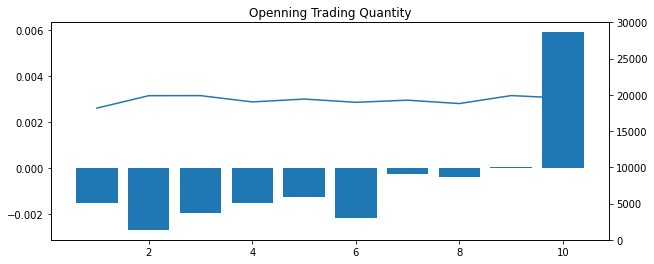

In [43]:
fig = plt.figure(figsize = [10,4])
ax1 = fig.add_subplot(111)
ax1.set_title('Openning Trading Quantity')
ax1.bar(range(1,len(openningQuanBandReturn)+1), openningQuanBandReturn)
ax2 = ax1.twinx()
ax2.plot(range(1,len(openningQuanBandCount)+1), openningQuanBandCount)
ax2.set_yticks([i*5000 for i in range(7)])
plt.show()

In [44]:
isSelected = pd.DataFrame(data = None,index = tradingDate,columns = allStockCode, dtype = np.int8)
isSelected[(gaoKaiBandDF == 10) & (openningQuanBandDF < 7) & (turnoverBandDF < 5)] = 1
#isSelected = diKaiBandDF[(diKaiBandDF == 10)]
(isSelected == 1).sum().sum()

5301

In [45]:
strategyReturn = dailyReturnDF[isSelected == 1].mean(axis=1).mean()
winCount = (dailyReturnDF[isSelected == 1] > 0).sum().sum()

In [46]:
winCount/(isSelected == 1).sum().sum()

0.37219392567440107

In [47]:
strategyReturn

-0.005777959447243941

In [48]:
averageReturn = dailyReturnDF[isValidDF == 1].mean(axis=1).mean()

In [49]:
averageReturn

-0.0012244450009273062